In [1]:
from visual_transformer import *

In [2]:
device = torch.device('cuda:1') # the big machine

In [3]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce RTX 2080 Ti
Tesla P40


In [4]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

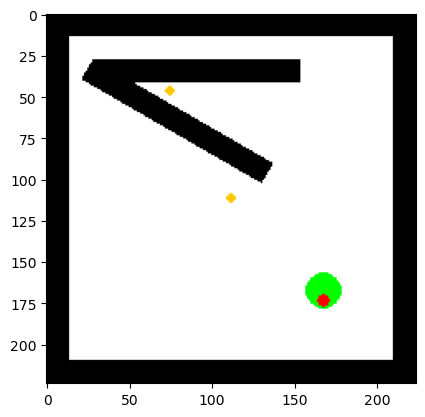

In [6]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [7]:
bare1_settings = G.random_bare_settings(gameSize=224, max_agent_offset=0.5)

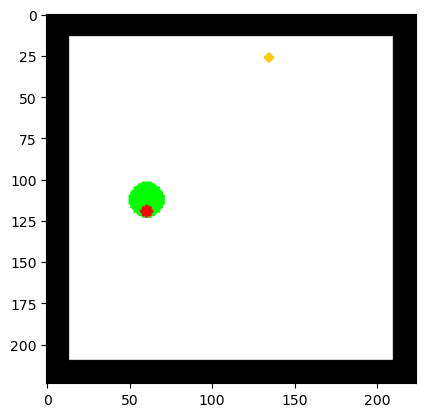

In [8]:
G2 = discreteGame(bare1_settings)
plt.imshow(G2.getData())

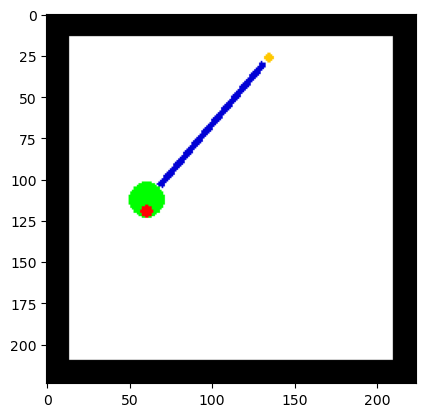

In [9]:
G2.bare_draw_arrow_at_gold()
plt.imshow(G2.getData())

In [10]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [11]:
# Task 1: just draw the arrow

In [12]:
vocab_size = 10000
# tokenizer.save_model(".", "tokenizer/eng_sentences_tokenizer_vc10000")
tokenizer = ByteLevelBPETokenizer(
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-vocab.json",
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-merges.txt",
)   
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)   
tokenizer.enable_truncation(max_length=32)
tokenizer.enable_padding()

In [13]:
task1_prompts = [ \
    "Imagine the line from the agent to the nearest gold.", \
    "What's the straight path from the agent to the gold?", \
    "Please draw the straight line to the gold from the agent.", \
    "How would you move from the agent to the gold?", \
    "What's a direct path from the agent to the gold?", \
    "From the agent to the nearest coin, please draw a path." ]

In [14]:
task1_text_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task1_prompts)]).contiguous().to(device)

In [15]:
task1_text_tensor

tensor([[   0, 7121,  655,  648,  275, 2641,  496,  275, 7407,  271,  275, 6598,
         3118,   18,    2],
        [   0,  510,  325,  275, 2733, 3871,  496,  275, 7407,  271,  275, 3118,
           35,    2,    0],
        [   0, 1029, 2710,  275, 2733, 2641,  271,  275, 3118,  496,  275, 7407,
           18,    2,    0],
        [   0,  589,  446,  296, 1723,  496,  275, 7407,  271,  275, 3118,   35,
            2,    0,    0],
        [   0,  510,  325,  263, 3064, 3871,  496,  275, 7407,  271,  275, 3118,
           35,    2,    0],
        [   0, 3873,  275, 7407,  271,  275, 6598, 7164,   16, 1328, 2710,  263,
         3871,   18,    2]], device='cuda:1')

In [16]:
task1_text_tensor.size()

torch.Size([6, 15])

In [17]:
inds = torch.randint(0, 6, size=(10,), device=device)
inds

tensor([5, 4, 0, 1, 5, 0, 0, 1, 0, 2], device='cuda:1')

In [18]:
text_sample = task1_text_tensor[inds]
text_sample.size()

torch.Size([10, 15])

In [19]:
# output format: image in, image out, text context
# no output text for now

def task1_img_sample(num_sample=40):
    img_in = torch.zeros(num_sample, 224, 224, 3)
    img_out = torch.zeros(num_sample, 224, 224, 3)
    for i in range(num_sample):
        bare_settings = G.random_bare_settings(gameSize=224, max_agent_offset=0.5)
        G2 = discreteGame(bare_settings)
        img_in[i] = torch.tensor(G2.getData())
        G2.bare_draw_arrow_at_gold()
        img_out[i] = torch.tensor(G2.getData())
    img_in = torch.permute(img_in, (0, 3, 1, 2)).contiguous().to(device)
    img_out = torch.permute(img_out, (0, 3, 1, 2)).contiguous().to(device)
    num_texts = task1_text_tensor.size()[0]
    text_inds = torch.randint(0, num_texts, size=(num_sample,), device=device)
    texts = task1_text_tensor[text_inds]
    return img_in, img_out, texts

In [20]:
inp, out, texts = task1_img_sample()

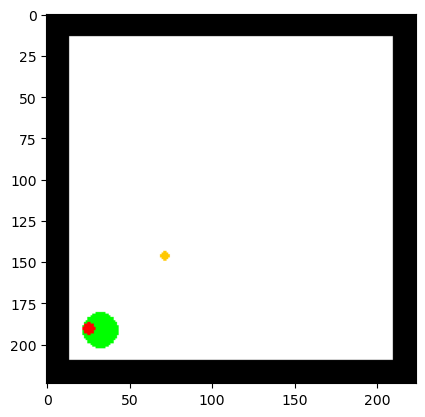

In [21]:
quick_display(inp[3])

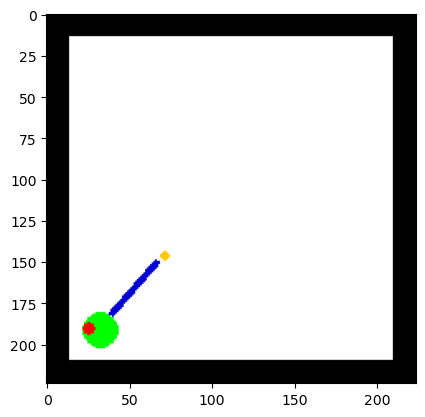

In [22]:
quick_display(out[3])

In [23]:
criterion = nn.MSELoss()

In [24]:
# Ok, let's set up the brain

In [25]:
brain = DefaultAgentBrain().to(device)

In [26]:
brain.img_enc.load_state_dict(torch.load('brain_checkpoints/img_encoder_weights_v10_batch12399.pth', weights_only=True))
brain.img_dec.load_state_dict(torch.load('brain_checkpoints/img_decoder_weights_v10_batch12399.pth', weights_only=True))

<All keys matched successfully>

In [27]:
brain.text_enc.load_state_dict(torch.load('brain_checkpoints/text_encoder_weights_v6.pth', weights_only=True))
brain.text_dec.load_state_dict(torch.load('brain_checkpoints/text_decoder_weights_v6.pth', weights_only=True))

<All keys matched successfully>

In [28]:
# No text learning today; only image

In [29]:
optimizer = optim.Adam(brain.parameters(), lr=0.00001, eps=1e-9) # not using 1e-5; too slow. If v10 collapses I'll retry with v6 img

In [ ]:
import time

total_batches = 6250*32

total_loss = 0
total_l1 = 0
total_l2 = 0
brain.train()
curr_min = 1.0
for b in range(total_batches):
    if b == 0:
        start = time.time()
    inp, out, texts = task1_img_sample(60)
    text_len = texts.size()[1]
    batch_size = inp.size()[0]
    task_text_context = brain.text_enc(texts)
    rand_text_context = torch.randn((batch_size, text_len, 768), device=device) # easier for pretraining to use randn
    task_recon = brain.img_autoencoder(inp, task_text_context)
    norm_recon = brain.img_autoencoder(inp, rand_text_context)
    l1 = criterion(task_recon, out)
    l2 = criterion(norm_recon, inp)
    loss = l1 + l2 # may add coefficients later
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    total_l1 += l1.item()
    total_l2 += l2.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        if avg_loss < curr_min:
            curr_min = avg_loss
            torch.save(brain.state_dict(), f'brain_checkpoints/brain_weights_tutorial1_v2_batch{b + 1}.pth')
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")

/home/atbolsh/anaconda3/envs/player/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Time for 1 batch: 3.950930595397949 seconds


In [ ]:
quick_display(inp[4])

In [ ]:
quick_display(task_recon[1])

In [ ]:
quick_display(norm_recon[1])

In [ ]:
# First attempt: just erases the image
# May need lower lr to actually crack this nut.